# 0. Setup Paths

In [8]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key = "aJYHYdVJLfR1sQPVAwwE")
project = rf.workspace("fona").project("food-detection-yvcmw")
dataset = project.version(5).download("tfrecord")
dataset.location

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Food-Detection-5 in tfrecord:: 100%|██████████| 11/11 [00:00<00:00, 27.31it/s]


'/content/Food-Detection-5'

In [9]:
import os

In [10]:
CUSTOM_MODEL_NAME = 'EfficientDet_D4'
PRETRAINED_MODEL_NAME = 'efficientdet_d4_coco17_tpu-32'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d4_coco17_tpu-32.tar.gz'

TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [11]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME),
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'),
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'),
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'),
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [12]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME),
    'TRAIN_LABELMAP': os.path.join(dataset.location, 'train', 'food_label_map.pbtxt'),
    'VAL_LABELMAP': os.path.join(dataset.location, 'valid', 'food_label_map.pbtxt'),
    'TRAIN_TFRECORD': os.path.join(dataset.location, 'train', 'food.tfrecord'),
    'VAL_TFRECORD': os.path.join(dataset.location, 'valid', 'food.tfrecord')
}

In [13]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [14]:
# https://www.tensorflow.org/install/source_windows

In [15]:
if os.name=='nt':
    !pip install wget
    import wget

In [16]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [17]:
# Install Tensorflow Object Detection
if os.name=='posix':
    # !apt-get install protobuf-compiler
    !sudo apt install -y protobuf-compiler
    !pip install cython
    !pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

# if os.name=='nt':
#     url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
#     wget.download(url)
#     !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
#     !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
#     os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))
#     !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
#     !cd Tensorflow/models/research/slim && pip install -e .

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
protobuf-compiler is already the newest version (3.12.4-1ubuntu7.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
  Cloning https://github.com/philferriere/cocoapi.git to /tmp/pip-req-build-__8lsc0i
  Running command git clone --filter=blob:none --quiet https://github.com/philferriere/cocoapi.git /tmp/pip-req-build-__8lsc0i
  Resolved https://github.com/philferriere/cocoapi.git to commit 2929bd2ef6b451054755dfd7ceb09278f935f7ad
  Preparing metadata (setup.py) ... done
Processing /content/Tensorflow/models/research
  Preparing metadata (setup.py) ... done
  Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
  Using cached tensorboard-2.15.1-py3-none-any.whl (5.5 MB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl (441 kB)
  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Created wheel for object-

In [18]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

2023-12-01 14:55:23.874805: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 14:55:23.874854: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 14:55:23.876009: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 14:55:25.282170: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-12-01 14:55:29.312463: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the gui

In [19]:
# !pip install tensorflow --upgrade

In [20]:
!pip install tensorflow==2.13.0

  Using cached tensorflow-2.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (524.1 MB)
  Using cached keras-2.13.1-py3-none-any.whl (1.7 MB)
  Using cached tensorboard-2.13.0-py3-none-any.whl (5.6 MB)
  Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl (440 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ER

In [21]:
# !pip uninstall protobuf matplotlib -y
# !pip install protobuf matplotlib==3.2

In [22]:
import object_detection

In [23]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.6
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
apache-beam                      2.52.0
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
avro-python3                     1.10.2
Babel                            2.13.1
backcall                         0.2.0
b

In [24]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

--2023-12-01 14:57:11--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d4_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.74.207, 173.194.192.207, 209.85.145.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.74.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 158496448 (151M) [application/x-tar]
Saving to: ‘efficientdet_d4_coco17_tpu-32.tar.gz’

efficientdet_d4_coc 100%[===================>] 151.15M   245MB/s    in 0.6s    

2023-12-01 14:57:12 (245 MB/s) - ‘efficientdet_d4_coco17_tpu-32.tar.gz’ saved [158496448/158496448]

efficientdet_d4_coco17_tpu-32/
efficientdet_d4_coco17_tpu-32/checkpoint/
efficientdet_d4_coco17_tpu-32/checkpoint/ckpt-0.data-00000-of-00001
efficientdet_d4_coco17_tpu-32/checkpoint/checkpoint
efficientdet_d4_coco17_tpu-32/checkpoint/ckpt-0.index
efficientdet_d4_coco17_tpu-32/pipeline.config
efficientdet_d4_coco17_tpu-32/saved_mod

# 2. Create Label Map

In [25]:
# labels = [{'name':'ThumbsUp', 'id':1}, {'name':'ThumbsDown', 'id':2}, {'name':'ThankYou', 'id':3}, {'name':'LiveLong', 'id':4}]

# with open(files['LABELMAP'], 'w') as f:
#     for label in labels:
#         f.write('item { \n')
#         f.write('\tname:\'{}\'\n'.format(label['name']))
#         f.write('\tid:{}\n'.format(label['id']))
#         f.write('}\n')

# 3. Create TF records

In [26]:
# # OPTIONAL IF RUNNING ON COLAB
# ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
# if os.path.exists(ARCHIVE_FILES):
#   !tar -zxvf {ARCHIVE_FILES}

In [27]:
# if not os.path.exists(files['TF_RECORD_SCRIPT']):
#     !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [28]:
# !python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')}
# !python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')}

# 4. Copy Model Config to Training Folder

In [29]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# 5. Update Config For Transfer Learning

In [30]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [31]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [32]:
config

{'model': ssd {
   num_classes: 90
   image_resizer {
     keep_aspect_ratio_resizer {
       min_dimension: 1024
       max_dimension: 1024
       pad_to_max_dimension: true
     }
   }
   feature_extractor {
     type: "ssd_efficientnet-b4_bifpn_keras"
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
         }
       }
       activation: SWISH
       batch_norm {
         decay: 0.9900000095367432
         scale: true
         epsilon: 0.0010000000474974513
       }
       force_use_bias: true
     }
     bifpn {
       min_level: 3
       max_level: 7
       num_iterations: 7
       num_filters: 224
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 1.0
       x_scale: 1.0
       height_scale: 1.0
       width_scale: 1.0
     }
   }
   matcher {
     argmax_m

In [33]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

In [34]:
pipeline_config.model.ssd.num_classes = 140
pipeline_config.train_config.batch_size = 1
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['TRAIN_LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [files['TRAIN_TFRECORD']]
pipeline_config.eval_input_reader[0].label_map_path = files['VAL_LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [files['VAL_TFRECORD']]

In [35]:
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:
    f.write(config_text)

In [36]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
config

{'model': ssd {
   num_classes: 140
   image_resizer {
     keep_aspect_ratio_resizer {
       min_dimension: 1024
       max_dimension: 1024
       pad_to_max_dimension: true
     }
   }
   feature_extractor {
     type: "ssd_efficientnet-b4_bifpn_keras"
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
         }
       }
       activation: SWISH
       batch_norm {
         decay: 0.9900000095367432
         scale: true
         epsilon: 0.0010000000474974513
       }
       force_use_bias: true
     }
     bifpn {
       min_level: 3
       max_level: 7
       num_iterations: 7
       num_filters: 224
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 1.0
       x_scale: 1.0
       height_scale: 1.0
       width_scale: 1.0
     }
   }
   matcher {
     argmax_

# 6. Train the model

In [37]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [38]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=1000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [39]:
print(command)

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/EfficientDet_D4 --pipeline_config_path=Tensorflow/workspace/models/EfficientDet_D4/pipeline.config --num_train_steps=1000


In [40]:
!{command}

2023-12-01 14:57:16.575815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-12-01 14:57:24.509151: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I1201 14:57:24.510362 138051537944576 mirrored_strategy.py:419] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 1000
I1201 14:57:24.546633 138051537944576 config_util.py:552] Maybe overwriting train_steps: 1000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I1201 14:57:24.546859 138051537944576 config_util.py:552] Maybe overwriting use_bfloat16: False
I1201 14:57:24.817552 138051537944576 ssd_efficientnet_bifpn_feature_extractor.py:161] EfficientDet EfficientNet

# 7. Evaluate the Model

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [ ]:
print(command)

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/EfficientDet_D4 --pipeline_config_path=Tensorflow/workspace/models/EfficientDet_D4/pipeline.config --checkpoint_dir=Tensorflow/workspace/models/EfficientDet_D4


In [ ]:
!{command}

2023-11-30 02:31:45.641266: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
W1130 02:31:49.512178 132149170226304 model_lib_v2.py:1089] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I1130 02:31:49.512419 132149170226304 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I1130 02:31:49.512519 132149170226304 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I1130 02:31:49.512617 132149170226304 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W1130 02:31:49.512741 132149170226304 model_lib_v2.py:1106] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
2023-11-30 02:31:51.773411: W tensorflow/core/common_runtime/gpu/gpu_bfc_alloca

# 8. Load Train Model From Checkpoint

In [41]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [43]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [44]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [45]:
category_index = label_map_util.create_category_index_from_labelmap(files['TRAIN_LABELMAP'])

In [54]:
# IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'livelong.02533422-940e-11eb-9dbd-5cf3709bbcc6.jpg')
IMAGE_PATH = '/content/stock-photo-nasi-ayam-goreng-kentucky-or-fried-chicken-rice-on-white-plate-on-red-background-the-most-favorite-1496224736.jpg'

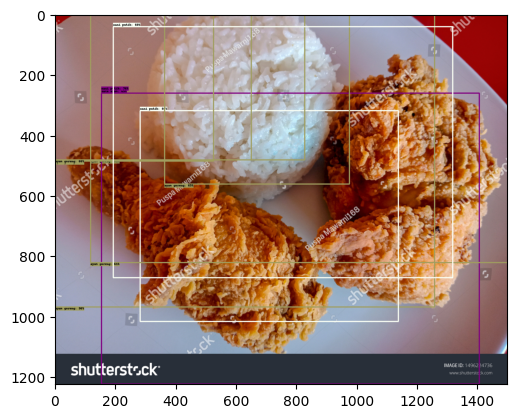

In [55]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=10,
            min_score_thresh=.6,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [59]:
IMAGE_PATH = '/content/resep-nasi-goreng-kecap-manis_43.jpeg'

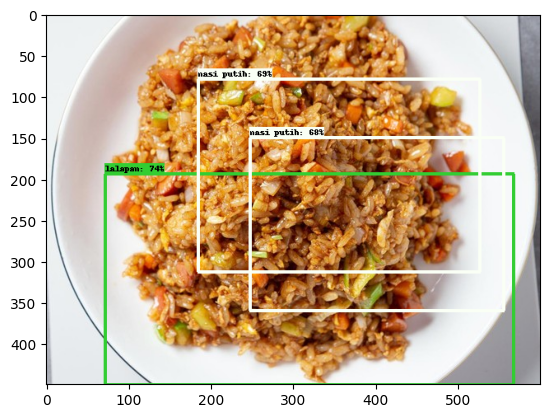

In [60]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=10,
            min_score_thresh=.6,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [56]:
detections['detection_scores']

array([0.9561    , 0.87849194, 0.81486666, 0.7624552 , 0.7299349 ,
       0.6568308 , 0.6526272 , 0.6511788 , 0.61249244, 0.6040832 ,
       0.5998852 , 0.58538204, 0.56613773, 0.51014644, 0.50673705,
       0.4875829 , 0.45027736, 0.42761093, 0.4170193 , 0.40949517,
       0.37904525, 0.36949202, 0.30861092, 0.30674335, 0.2952958 ,
       0.2833582 , 0.27941355, 0.2543417 , 0.24921687, 0.2478272 ,
       0.23563093, 0.2260172 , 0.22032918, 0.21325389, 0.19141294,
       0.19032826, 0.18983074, 0.18950577, 0.17734407, 0.17578393,
       0.17475711, 0.16750519, 0.16191399, 0.15459917, 0.14487363,
       0.14421818, 0.14152731, 0.14004914, 0.1381322 , 0.13147864,
       0.12955397, 0.12754227, 0.12542598, 0.12394425, 0.12235612,
       0.11886842, 0.11788651, 0.11770279, 0.11363532, 0.1117396 ,
       0.10794234, 0.10521448, 0.10424361, 0.10224051, 0.10149989,
       0.09920592, 0.09860944, 0.09833941, 0.09820209, 0.09729449,
       0.09467864, 0.09451424, 0.09339859, 0.09215081, 0.09172

In [57]:
detections['detection_classes']+label_id_offset

array([ 10,  77,  10,  77,  10,  10,  10,  97,  10,  77,  10,  77,  10,
        77,  97,  74,  77,  10,  77,  77,  10,  74,  10,  10,  10,  77,
        77,  10,  77,  10,  97,  74, 123,  74,  10,  77,  77,  77,  77,
        10,  10,  77,  77,  74,  66,  97,  77,  77,  74, 123,  10,  66,
        74,  66,  10,  77,  77,  74,  74,  10,  10,  72,  10,  74,  77,
        72,  77,  10,  73,  77,  66,  66,  74,  10,  66,  66,  77,  97,
        77,  66,  77,  77,  77,  97, 123,  73,  74,  10,  73,  74,  12,
       123,  74,  66,  12,  10,  97, 123,  97,  77])

In [58]:
category_index

{1: {'id': 1, 'name': 'Pisang'},
 2: {'id': 2, 'name': 'Sambal kentang'},
 3: {'id': 3, 'name': 'Teri goreng'},
 4: {'id': 4, 'name': 'ati ampela'},
 5: {'id': 5, 'name': 'ayam asam manis'},
 6: {'id': 6, 'name': 'ayam bakar'},
 7: {'id': 7, 'name': 'ayam cabai garam'},
 8: {'id': 8, 'name': 'ayam cabai hijau'},
 9: {'id': 9, 'name': 'ayam geprek'},
 10: {'id': 10, 'name': 'ayam goreng'},
 11: {'id': 11, 'name': 'ayam gulai'},
 12: {'id': 12, 'name': 'ayam katsu'},
 13: {'id': 13, 'name': 'ayam kecap'},
 14: {'id': 14, 'name': 'ayam kentucky'},
 15: {'id': 15, 'name': 'ayam penyet'},
 16: {'id': 16, 'name': 'ayam rica-rica'},
 17: {'id': 17, 'name': 'ayam saos gravy'},
 18: {'id': 18, 'name': 'ayam saos mentai'},
 19: {'id': 19, 'name': 'ayam saus keju'},
 20: {'id': 20, 'name': 'ayam saus spicy galbi'},
 21: {'id': 21, 'name': 'ayam suwir'},
 22: {'id': 22, 'name': 'ayam teriyaki'},
 23: {'id': 23, 'name': 'ayam woku'},
 24: {'id': 24, 'name': 'bakso'},
 25: {'id': 25, 'name': 'bakso 

# 10. Real Time Detections from your Webcam

In [ ]:
!pip uninstall opencv-python-headless -y

In [ ]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened():
    ret, frame = cap.read()
    image_np = np.array(frame)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))

    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# 10. Freezing the Graph

In [ ]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [ ]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [ ]:
print(command)

python Tensorflow\models\research\object_detection\exporter_main_v2.py  --input_type=image_tensor --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --trained_checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet --output_directory=Tensorflow\workspace\models\my_ssd_mobnet\export


In [ ]:
!{command}

2021-04-03 11:51:42.281339: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-03 11:51:44.712115: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-03 11:51:44.712813: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-04-03 11:51:44.734951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:2b:00.0 name: GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.785GHz coreCount: 40 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2021-04-03 11:51:44.734976: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-03 11:51:44.738520: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cublas64_11.dll
202

# 11. Conversion to TFJS

In [57]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 92.5 MB/s eta 0:00:00
  Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
  Using cached tensorboard-2.15.1-py3-none-any.whl (5.5 MB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl (441 kB)
  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.13.0
    Uninstalling tensorboard-2.13.0:
      Successfully uninstalled tensorboard-2.13.0
  Attempting

In [58]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [59]:
print(command)

tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default Tensorflow/workspace/models/EfficientDet_D4/export/saved_model Tensorflow/workspace/models/EfficientDet_D4/tfjsexport


In [60]:
!{command}

2023-12-01 14:22:04.631702: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 14:22:04.631759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 14:22:04.633454: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 14:22:06.232192: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 958, in pip_main
    

In [ ]:
# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS

# 12. Conversion to TFLite

In [ ]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [ ]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [ ]:
print(command)

python Tensorflow\models\research\object_detection\export_tflite_graph_tf2.py  --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --trained_checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet --output_directory=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport


In [ ]:
!{command}

2021-04-03 11:55:05.530772: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-03 11:55:08.004889: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-03 11:55:08.005672: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-04-03 11:55:08.028532: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:2b:00.0 name: GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.785GHz coreCount: 40 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2021-04-03 11:55:08.028559: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-03 11:55:08.032092: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cublas64_11.dll
202

2021-04-03 11:55:14.884114: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 
2021-04-03 11:55:14.884117: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N 
2021-04-03 11:55:14.884182: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1406] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 6611 MB memory) -> physical GPU (device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:2b:00.0, compute capability: 7.5)
2021-04-03 11:55:14.884197: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
W0403 11:55:15.360029 15552 save_impl.py:78] Skipping full serialization of Keras layer <object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch object at 0x00000224AC2B1908>, because it is not built.
W0403 11:55:15.925411 15552 save_impl.py:78] Skipping full serialization of Keras layer <tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x00000224D6D42B00>, bec

In [ ]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [ ]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [ ]:
print(command)

tflite_convert --saved_model_dir=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport\saved_model --output_file=Tensorflow\workspace\models\my_ssd_mobnet\tfliteexport\saved_model\detect.tflite --input_shapes=1,300,300,3 --input_arrays=normalized_input_image_tensor --output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' --inference_type=FLOAT --allow_custom_ops


In [ ]:
!{command}

2021-04-03 11:55:38.653963: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-03 11:55:41.159460: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-03 11:55:41.160164: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-04-03 11:55:41.183623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:2b:00.0 name: GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.785GHz coreCount: 40 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2021-04-03 11:55:41.183649: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-03 11:55:41.187402: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cublas64_11.dll
202

# 13. Zip and Export Models

In [55]:
!tar -czf EffDetD4_200.tar.gz {paths['CHECKPOINT_PATH']}

In [56]:
# from google.colab import drive
# drive.mount('/content/drive')

MessageError: ignored